<a id="top"></a>
# **4.1: Loading, unloading and reloading**

<!-- [![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=551829) part 1 -->

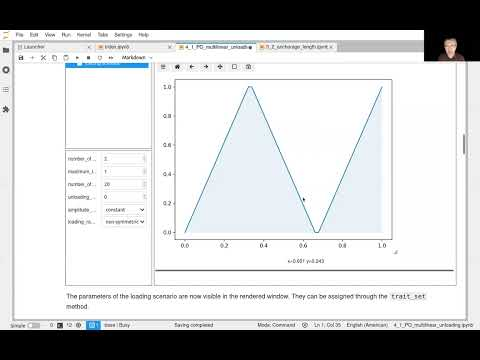

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('SCuoGg7_8GE')

<div style="background-color:lightgray;text-align:left"> <img src="../icons/start_flag.png" alt="Previous trip" width="40" height="40">
    &nbsp; &nbsp; <b>Starting point</b> </div> 

Once we have seen that there is a relation between the shape of the constitutive law and the  stress redistribution process within a bond zone which has an immediate consequence on the shape of the pullout curve, we extend our horizon to the case of **non-monotonic loading**.  

<div style="background-color:lightgray;text-align:left"> <img src="../icons/destination.png" alt="Previous trip" width="40" height="40">
    &nbsp; &nbsp; <b>Where are we heading</b> </div> 

To motivate a more general development of the model for the bond-slip behavior let us consider the case of non-monotonic loading. What happens in the material structure of the bond if the load is reduced and then it grows again?

# **Motivating examples**

Consider again the test double-sided pullout test introduced in [notebook 3.2](../tour3_nonlinear_bond/3_2_anchorage_length.ipynb#trc_pullout_study). Within this test series studying the nonlinear bond behavior of carbon fabrics, a loading scenario with introducing several **unloading and reloading steps** has been included for the specimen with the total length of 300 and 400 mm. The obtained measured response looked as follows 
![image](../fig/test_unloading.png)

**Question:** Can the  pullout models from tours 2 and 3 be used to describe such kind of behavior? What constitutive law  can reproduce this kind of behavior? 

**Answer:** The bond-slip laws presented so far only considered monotonically increasing load and cannot reproduce the real material behavior upon unloading. 
The constant-bond slip model in Tour 2 and the multilinear bond-slip model exemplified in Tour 3 did not consider any change of behavior upon unloading. 
To document this statement and to show how to introduce unloading and reloading into the interactive numerical models  that we used in Tour 3, an example has been prepared showing how to introduce a more complex type of loading into the model.

<a id="trc_study_monotonic"></a>
### **Example 1:** TRC specimen with unloading

Let us reuse the geometrical, material and algorithmic parameters already specified in the  
[case study on carbon fabric bond](../tour3_nonlinear_bond/3_2_anchorage_length.ipynb#case_study_1)

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from bmcs_cross_section.pullout import PullOutModel1D
po_trc = PullOutModel1D(n_e_x=100, w_max=3) # mm 
po_trc.geometry.L_x=150 # [mm]
po_trc.time_line.step = 0.02
po_trc.cross_section.trait_set(A_m=1543, A_f=16.7, P_b=10)
po_trc.material_model='multilinear'
po_trc.material_model_.trait_set(
    E_m=28000, E_f=170000,
    s_data = '0, 0.1, 0.5, 1, 2, 3,   4.5, 6', 
    tau_data = '0, 5.4, 4.9, 5, 6, 7, 8.3, 9'
);

In addition, let us now change the `loading_scenario` to `cyclic` load.
Note that this polymorphic attribute changes the 'shadowed' object
which generates the time function for the scaling of the load. The 
shadowed object representing the cyclic loading scenario can then 
be accessed as an attribute `loading_scenario_`. It can be rendered 
using the `interact` method, like any other model component in the
model tree

In [7]:
po_trc.loading_scenario.profile = 'cyclic-nonsym-incr'
po_trc.loading_scenario.interact()

xxxxx


The parameters of the loading scenario are now visible in the rendered window. They can be 
assigned through the `trait_set` method.

In [8]:
po_trc.loading_scenario.profile_.trait_set(number_of_cycles=1,
                              unloading_ratio=0.0,
                               numbe_of_increments=200);

The model can now be executed and rendered.

In [9]:
po_trc.reset()
po_trc.run()
po_trc.interact()

Apparently, there is no significant difference directly visible. However, if you browse through the history, it will be obvious that unloading is running along the same path as loading, which contradicts to the behavior observed in experiments.

### **Example 2:** CFRP with unloading

Even more evident demonstration of the non-physicality of the applied model can be provided by reusing the calibrated CFRP model. Let us apply the same loading scenario again

In [8]:
A_f = 16.67 # [mm^2]
A_m = 1540.0 # [mm^2]
p_b = 100.0 #
E_f = 170000 # [MPa]
E_m = 28000 # [MPa]
pm = PullOutModel1D()
pm.material_model = 'multilinear'
pm.material_model_.s_data = "0, 0.1, 0.4, 4"
pm.material_model_.tau_data = "0, 8, 0, 0"
pm.sim.tline.step = 0.01 # 100 time increments
pm.cross_section.trait_set(A_f=A_f, P_b=p_b, A_m=A_m)
pm.geometry.L_x = 300 # length of the specimen [mm]
pm.w_max = 1.8 # maximum control displacement [mm]
pm.n_e_x = 100 # number of finite elements
pm.loading_scenario.profile = 'cyclic-nonsym-const'
pm.loading_scenario.profile_.trait_set(number_of_cycles=2,
                              unloading_ratio=0.0,
                               numbe_of_increments=200)
pm.run()
pm.interact()

Browsing through the history will reveal that the debonded zone gets recovered upon unloading as the process zone travels back through the bond zone and the pullout tests gets completely healed once $w = 0$. This motivates the question: **How to introduce irreversible changes in the material structure** so that we reflect the physics behind the scenes in a correct way.

<a id="plasticity_and_damage"></a>
# **Physical explanation of the bond behavior**

<!-- [![title](../fig/bmcs_video.png)](https://moodle.rwth-aachen.de/mod/page/view.php?id=551829) part 2 -->

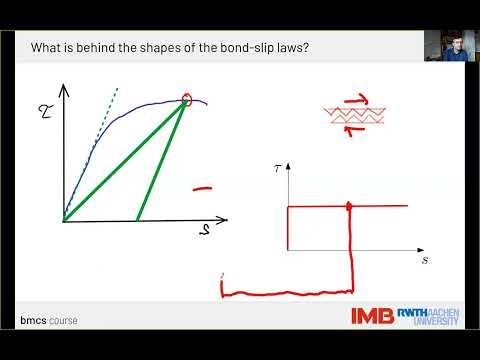

In [10]:
YouTubeVideo('btj1SgUjBeA')

Regarding a small segment of the bond interface with a nearly constant shear stress $\tau$ and constant 
slip $s$ let us try to describe the correspondence between the micro- and meso-scopic mechanisms that actually govern 
bond-slip relation $\tau(s)$. To classify the elementary mechanisms behind the observed bond behavior, let us can idealize 
the material structure of the bond using two types of bindings:

 - as a **series of elastic springs** that can break once they achieve their strength, and 
 - as a **series of asperities** representing an unevenness or roughness of the surface area. 
   Sliding of these surfaces is accompanied with a stress required to cross over the asperities. During this process the asperities can deform elastically or get abraded.

With this simple image of the material interface we can try to associate the structure of the bond layer with the basic types of inelastic material behavior, namely, damage and plasticity. In most cases both types of material behavior occur. The question is, how to distinguish and quantify them.

**Damage:** Consider an infinitesimal material point of the interface exhibiting softening response upon monotonic loading. Upon unloading, this material point would unload to origin. This behavior can be reproduced by an idealization of the material point as a series of elastic springs. Assuming further a scatter of spring strength, the failure of one spring upon increasing slip displacement $s$ leads to the reduction of the bond stiffness and overall stress level $\tau$. Since all the remaining springs are elastic, they would all unload to the origin.

![damage](../fig/damage.png)

**Plasticity:**
On the other hand, if a bond stress is transferred by asperities, we can distinguish two phases of response. Before the stress necessary to skip over an asperity has been reached, the slip is zero. At the onset of sliding over the asperities, the slip can increase at constant level of stress. Once the stress level is reduced, the slip does not change. Or putting it differently, the stress needed to induce sliding over the surface remains constant. Once the sliding direction is changed, also the sign of the shear stress must change. The described type of behavior is referred to as ideally plastic. This kind of material response is shown as the curve (2) 
![plasticity](../fig/plasticity.png)

If asperities can deform before reaching the onset of sliding, an elastic deformation can be observed as indicated
by the curve (3).

**Interactions:** Usually, both damage and plasticity encounter simultaneously in the material behavior. Both introduce energy dissipation. While damage is connected with the reduction of the material stiffness, plasticity leads to permanent deformation after unloading of the structure. To understand the effect of damage and plasticity at the level of a material point, we will construct simple models that can be used within the BMCS interactive sheets to understand the two types of material behavior in detail.

Corresponding to this classification, we will address the two categories of behavior in a more
detailed way:

1. starting with interactive studies for non-monotonic loading scenarios, 
2. providing a mathematical framework for the description of plasticity and damage exemplified for the bond-behavior at a material point level
3. studying the effect of plasticity and damage at the structural level using pullout tests.

<div style="background-color:lightgray;text-align:left;width:45%;display:inline-table;"> <img src="../icons/previous.png" alt="Previous trip" width="50" height="50">
    &nbsp; <a href="../tour3_nonlinear_bond/3_2_anchorage_length.ipynb#top">3.2 Anchorage length</a> 
</div><div style="background-color:lightgray;text-align:center;width:10%;display:inline-table;"> <a href="#top"><img src="../icons/compass.png" alt="Compass" width="50" height="50"></a></div><div style="background-color:lightgray;text-align:right;width:45%;display:inline-table;"> 
    <a href="4_2_BS_EP_SH_I_A.ipynb#top">4.2 Basic concept of plasticity</a>&nbsp; <img src="../icons/next.png" alt="Previous trip" width="50" height="50"> </div> 